# Variational inference using the finite approximation

trying standard cavi

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [2]:
np.random.seed(43141) 

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([Num_samples,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
# A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?
A = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))
print(A)

# draw noise
# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)
epsilon = np.random.normal(0, sigma_eps, (Num_samples, D))

# the observed data
X = np.dot(Z,A) + epsilon


true Z (first 10 rows): 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]
[[-3.07199514  5.0220693 ]
 [ 9.54417571  3.59640607]
 [ 1.1894611  -8.60276614]]


# set initializations

In [3]:
K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000
elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)


Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}


In [4]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)

# run CAVI

In [6]:
 
for i in range(iterations):
    iter_ran = i + 1

    cavi_updates(tau, nu, phi_mu, phi_var, X, alpha, sigmas)

    round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

    [elbo[i],elbo_Term1[i],elbo_Term2[i],elbo_Term3[i],elbo_Term4[i],elbo_Term5[i],elbo_Term6[i],elbo_Term7[i]] \
        = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)
    #elbo[i] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)

    print('iteration: ', i, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), 'elbo: ', elbo[i])
    #print(round_nu[0:10,:])

    if np.isnan(elbo[i]):
        print('NAN ELBO.')
        break

    if (i>0) & (elbo[i] < elbo[i-1]): 
        print('elbo decreased!  Difference: ', elbo[i] - elbo[i-1])
        break

    if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8):
        print('ELBO converged')
        break
    

iteration:  0  l1 error:  0.333998637389 elbo:  -22338.9689026
iteration:  1  l1 error:  0.326000149186 elbo:  -17344.3515966
iteration:  2  l1 error:  0.326 elbo:  -14076.9191244
iteration:  3  l1 error:  0.326 elbo:  -12071.3526048
iteration:  4  l1 error:  0.326000006456 elbo:  -10860.7788128
iteration:  5  l1 error:  0.331346696597 elbo:  -9774.5593934
iteration:  6  l1 error:  0.331999139625 elbo:  -9095.98630658
iteration:  7  l1 error:  0.325321603262 elbo:  -8480.79071147
iteration:  8  l1 error:  0.322000000263 elbo:  -7875.78857669
iteration:  9  l1 error:  0.322 elbo:  -7526.73905912
iteration:  10  l1 error:  0.322 elbo:  -7317.45874529


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:69: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)


iteration:  11  l1 error:  0.322 elbo:  -7194.54230031
iteration:  12  l1 error:  0.322 elbo:  -7122.58855712
iteration:  13  l1 error:  0.322 elbo:  -7080.48866123
iteration:  14  l1 error:  0.322 elbo:  -7055.85797133
iteration:  15  l1 error:  0.322 elbo:  -7041.44785891
iteration:  16  l1 error:  0.322 elbo:  -7033.01727888
iteration:  17  l1 error:  0.322 elbo:  -7028.08500213
iteration:  18  l1 error:  0.322 elbo:  -7025.19939368
iteration:  19  l1 error:  0.322 elbo:  -7023.51118019
iteration:  20  l1 error:  0.322 elbo:  -7022.52349776
iteration:  21  l1 error:  0.322 elbo:  -7021.94565818
iteration:  22  l1 error:  0.322 elbo:  -7021.60759548
iteration:  23  l1 error:  0.322 elbo:  -7021.40981327
iteration:  24  l1 error:  0.322 elbo:  -7021.2941016
iteration:  25  l1 error:  0.322 elbo:  -7021.22640495
iteration:  26  l1 error:  0.322 elbo:  -7021.18679931
iteration:  27  l1 error:  0.322 elbo:  -7021.16362818
iteration:  28  l1 error:  0.322 elbo:  -7021.15007201
iteration: 

Z 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]
round_nu 
 [[ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  1.]]
[ 0.59558581  0.00660009  0.03001231]
[2 1 1]
Z permuted 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]]
true A
 [[-3.07199514  5.0220693 ]
 [ 9.54417571  3.59640607]
 [ 1.1894611  -8.60276614]]
phi_mu
 [[ 1.80126057 -4.42838106]
 [ 5.92088624  1.9610905 ]
 [ 1.76370281 -0.88947262]]


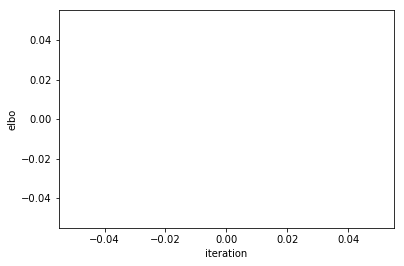

In [6]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
print('Z \n', Z[0:10,:])
print('round_nu \n', round_nu[0:10,:])

# Print the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]

print(np.min(accuracy_mat, 1))
print(np.argmin(accuracy_mat, 1))

print('Z permuted \n', Z[0:10,np.argmin(accuracy_mat, 1)])

print('true A\n', A)
print('phi_mu\n', phi_mu.transpose())

plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

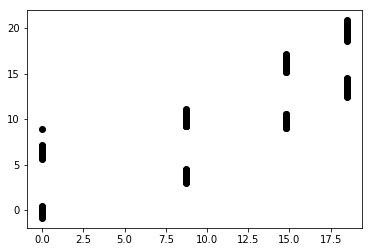

In [112]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

In [109]:
# let us permute the columms of nu and then compare: 
nu_perm = nu[:, (1,2,0)]
round_nu_perm = np.round(nu_perm*(nu_perm>=0.9) + nu_perm*(nu_perm<=0.1)) + nu_perm*(nu_perm>=0.1)*(nu_perm<=0.9)

print(np.sum(np.abs(Z[:,0] - nu_perm[:,0]))/Num_samples)
print(np.sum(np.abs(Z[:,1] - nu_perm[:,1]))/Num_samples)
print(np.sum(np.abs(Z[:,2] - nu_perm[:,2]))/Num_samples)

# so two of the rows are really close ...

0.9566
0.1538
0.706
